## Classify Images of Colon Cancer

isCancerous classification: Binary classification to detect whether a given colon cell image is cancerous or not.

cellType classification: Multi-class classification to categorize the cell type (e.g., fibroblast, epithelial, etc.).

### Step 1: Import Libraries and Set Device

In [3]:
import os
import optuna
import random
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Dataset Description

In this project, we utilized a colon histology image dataset accompanied by two different CSV files, each catering to a specific classification task. These CSVs and the associated image data formed the foundation for building, training, and evaluating machine learning models for both binary and multiclass classification.

1. CSV for Binary Classification (isCancerous)

Purpose: To train a model that predicts whether a given colon histology image is cancerous or not.

CSV Columns:

    ImageName: The filename of the image (e.g., img_001.png)

    isCancerous: Binary label

        0 – Non-cancerous
        1 – Cancerous

2. CSV for Multiclass Classification (cellType)

Purpose: To train a model that classifies images into one of four cell types.

CSV Columns:

    ImageName: The filename of the image

    cellType: Multiclass label (integer from 0 to 3), representing:

        0 – Fibroblast

        1 – Inflammatory

        2 – Epithelial

        3 – Others




### Step 2: Load CSV Data and Data Split

In [5]:
# Paths
main_csv = r'data_labels_mainData.csv'
extra_csv = r'data_labels_extraData.csv'
image_dir = r'patch_images'  # Update if image path is different

# Load CSVs
data_main = pd.read_csv(main_csv)
data_extra = pd.read_csv(extra_csv)

# For reference: check columns
print(data_main.columns)
print(data_extra.columns)

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')
Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')


#### Dataset Distribution

    Binary task (isCancerous)

        Classes: 0 (Non-cancerous), 1 (Cancerous)

Stratified split ensures class balance in train/val/test

#### Multi-class task (cellType)

    Classes: Multiple (e.g., fibroblast, epithelial, etc.)

Handled via label mapping and stratified splits to maintain proportional representation.

### Class Distribution

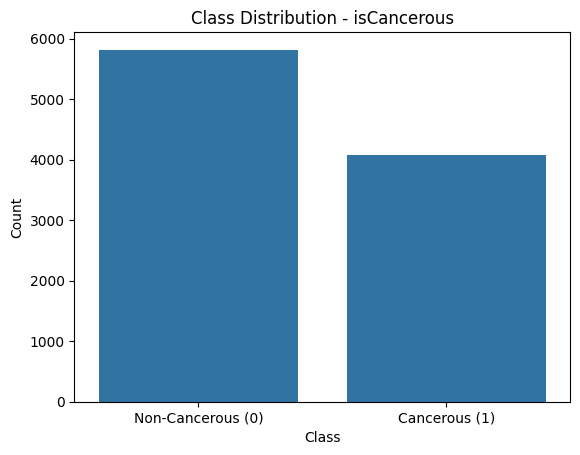

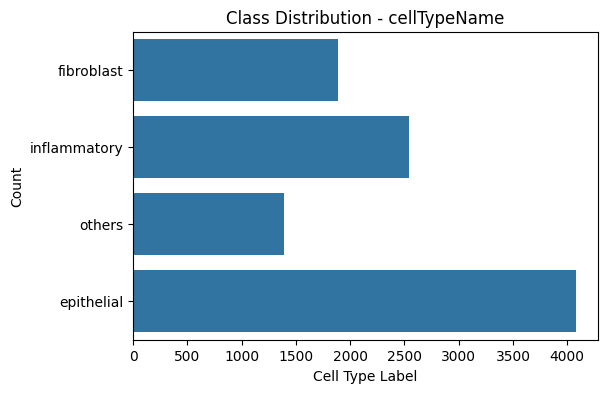

In [6]:
# Class distribution for isCancerous
sns.countplot(x='isCancerous', data=data_main)
plt.title('Class Distribution - isCancerous')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous (0)', 'Cancerous (1)'])  # Optional: better labels
plt.show()

# Class distribution for cellTypeName
plt.figure(figsize=(6, 4))
sns.countplot(data_main['cellTypeName'])
plt.title("Class Distribution - cellTypeName")
plt.xlabel("Cell Type Label")
plt.ylabel("Count")
plt.show()

Cancerous cells (label = 1) had significantly fewer samples compared to non-cancerous ones (label = 0). Similarly, certain cell types like Epithelial were more frequent than Others or Fibroblasts.

Implications:

    Models tend to bias towards the majority class, resulting in poor performance (e.g., lower recall) on minority classes.

    It affects overall model generalizability, especially in real-world settings where rare classes (e.g., cancerous cases) are clinically significant.


In [7]:
# Data Split

# For isCancerous model
df_cancer = data_main[['ImageName', 'isCancerous']]
train_df_cancer, val_df_cancer = train_test_split(df_cancer, test_size=0.2, stratify=df_cancer['isCancerous'], random_state=42)
test_df_cancer = data_extra[['ImageName', 'isCancerous']]

# For cellType model
train_df_type, temp_df = train_test_split(data_main, test_size=0.3, stratify=data_main['cellType'], random_state=42)
val_df_type, test_df_type = train_test_split(temp_df, test_size=0.5, stratify=temp_df['cellType'], random_state=42)

The dataset was divided into training, validation, and test sets using a stratified splitting strategy. For the isCancerous classification task, an 80/20 split was applied to the main dataset to form the training and validation sets, ensuring balanced class distribution. The extra dataset was used as an independent test set to assess generalization. For the cellType classification, the main dataset was split into 70% training, 15% validation, and 15% testing using stratified sampling based on cell type labels. This approach maintains label proportions across all splits and ensures robust model evaluation.